# Clean reindexation files from ABES - April 2023

Ce notebook a permis de verifier les fichiers de réindexation des reindexeurs de l'ABES. Une bonne partie des vérification est maintenant inutile mais par souci de clarté, j'ai préféré les laisser en cas de nouvelle réindexation. 

# Set project

### Packages

In [1]:
# Import librairies and useful functions
from sklearn.preprocessing import MultiLabelBinarizer

from utils_project import *
from utils_metrics import *
from utils_visualization import *

# Import data

In [2]:
# Include embeddings
include_embedding = True

In [3]:
# Original dataset
rameau_file = "rameau_Tf_Td.csv"
sudoc_file = "working_data_sans_dewey.pkl"
reindex_file = "reindexation_final_juin2023.csv"

In [4]:
#Import data
reindex = pd.read_csv(os.path.join(data_path, reindex_file), index_col=0)
print(reindex.shape)

(100, 16)


In [5]:
# Import SUDOC
sudoc = pd.read_pickle(os.path.join(data_path, sudoc_file))
print(sudoc.shape)

(154447, 10)


In [6]:
# Import rameau list
ram = pd.read_csv(os.path.join(data_path, rameau_file), index_col=0)
print("Nombre de notices différentes: ", ram.shape[0])
ram.head(5)

Nombre de notices différentes:  103628


PPN                   NOM                             URI
0  157992527                Kirp?n  https://www.idref.fr/157992527
1  110140494   Militaires artistes  https://www.idref.fr/110140494
2  028492161    Militaires romains  https://www.idref.fr/028492161
3  028521757  Militaires prussiens  https://www.idref.fr/028521757
4  029895561            Sa-skya-pa  https://www.idref.fr/029895561

## Merge SUDOC and reindexation files

In [7]:
df = reindex.merge(sudoc[["PPN", "RAMEAU_CHECKED", "rameau_chaines_index", "rameau_concepts"]], on="PPN", how="inner")
print(df.shape)

(100, 19)


# Analyse RAMEAU concepts

In [8]:
index_columns = [
    'INDEX_AFE', 'INDEX_MCR', 'INDEX_JMF',
    'INDEX_LPL', 'INDEX_LJZ','INDEX_MPD'
]

## Number of Indexation chains

In [9]:
df["nb_chaine_index_rameau"] = df["RAMEAU_CHECKED"].apply(lambda x: 0 if isinstance(x,float) else len(x.split(";")))
for col in index_columns:
    print("Dealing with ", col)
    index_name = col.split("_")[1]
    new_col_name = str("nb_chaine_index_" + index_name)
    df[new_col_name] = df[col].apply(lambda x: 0 if isinstance(x,float) else len(x.split(";;")))

Dealing with  INDEX_AFE
Dealing with  INDEX_MCR
Dealing with  INDEX_JMF
Dealing with  INDEX_LPL
Dealing with  INDEX_LJZ
Dealing with  INDEX_MPD


In [10]:
# Count nb of chain
cols = [
    "nb_chaine_index_rameau",
    "nb_chaine_index_AFE",
    "nb_chaine_index_MCR",
    "nb_chaine_index_JMF",
    "nb_chaine_index_LPL",
    "nb_chaine_index_LJZ",
    "nb_chaine_index_MPD"]

In [11]:
subset = df[cols].melt()
subset

variable  value
0    nb_chaine_index_rameau      7
1    nb_chaine_index_rameau      2
2    nb_chaine_index_rameau      1
3    nb_chaine_index_rameau      7
4    nb_chaine_index_rameau      2
..                      ...    ...
695     nb_chaine_index_MPD      2
696     nb_chaine_index_MPD      3
697     nb_chaine_index_MPD      3
698     nb_chaine_index_MPD      3
699     nb_chaine_index_MPD      3

[700 rows x 2 columns]

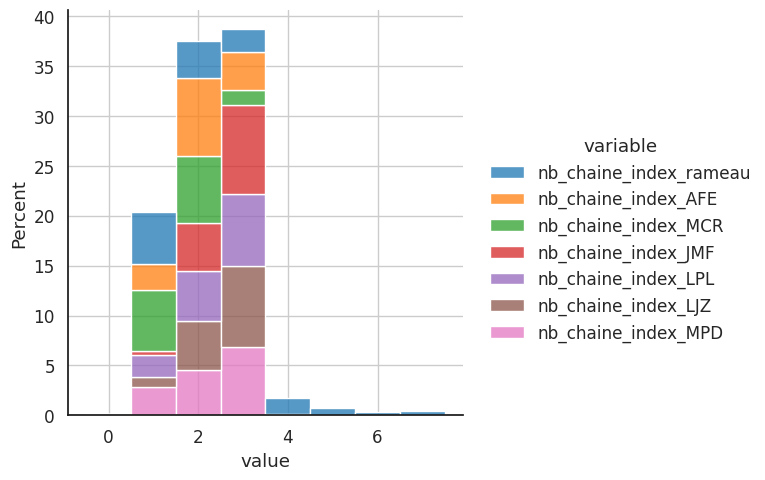

In [12]:
# Number of indexation chain
sns.displot(x="value", hue="variable", data=subset, palette="tab10", discrete=True, stat="percent", multiple="stack")

In [14]:
## Check for notices with more than a threshold
c = ["PPN", "TITRE", "RAMEAU_CHECKED"] + cols + index_columns
thres = 5
mask = df[cols] >= thres
high_nb_index_chain = df.loc[mask.sum(axis=1) >= 1, c]

In [15]:
high_nb_index_chain

PPN                                              TITRE   
0   000308838  Les sommets de l'État : essai sur l'élite du p...  \
3   058296182                         L'homme devant l'incertain   
20  159761875  Les sociétés coloniales à l'âge des empires : ...   
22  163093741  Le cri d'Archimède : l'art de la Découverte et...   
40  200404342  La fabrique des classiques africains : écrivai...   
50  231860838                              La justice prédictive   
63  248194305                                 Le travail du care   
73  257349006  Vivre plus simplement : analyse sociologique d...   
79  262267888  Ce que les GAFAM font aux médias africains : e...   
99  26753177X  Algocratie : allons-nous donner le pouvoir aux...   

                                       RAMEAU_CHECKED  nb_chaine_index_rameau   
0   Bureaucratie;Classes dirigeantes;Classes dirig...                       7  \
3   Chaos (théorie des systèmes);Incertitude;Libre...                       7   
20  Colonies;Colonies;Colonies;Colonisation -- Asp...                       7   
22  Créativité;Créativité en sciences;Découvertes ...                       5   
40  Littérature africaine de langue française -- A...                       5   
50  Droit -- Informatique -- Aspect moral;Droit et...                       5   
63  Aides-soignants -- Conditions de travail;Compo...                       5   
73  Auto-développement (psychothérapie);Changement...                       6   
79  Diffusion sélective de l'information;Géants du...                       6   
99  Algorithmes;Changement social;Informatique -- ...                       5   

    nb_chaine_index_AFE  nb_chaine_index_MCR  nb_chaine_index_JMF   
0                     2                    2                    3  \
3                     1                    1                    3   
20                    2                    2                    3   
22                    3                    2                    3   
40                    3                    2                    3   
50                    3                    2                    1   
63                    3                    2                    3   
73                    1                    2                    3   
79                    2                    2                    3   
99                    2                    2                    2   

    nb_chaine_index_LPL  nb_chaine_index_LJZ  nb_chaine_index_MPD   
0                     3                    3                    3  \
3                     2                    2                    3   
20                    2                    4                    3   
22                    2                    3                    3   
40                    3                    3                    2   
50                    3                    3                    3   
63                    3                    3                    3   
73                    2                    3                    2   
79                    3                    3                    3   
99                    2                    3                    3   

                                            INDEX_AFE   
0   Classes dirigeantes -- France -- Histoire;;Pou...  \
3                             Philosophie et sciences   
20  Colonialisme et ethnologie -- 1800-….;;Colonie...   
22  Découvertes scientifiques;;Création littéraire...   
40  Écrivains africains de la langue française -- ...   
50  Justice prédictive;;Processus judiciaire -- In...   
63  Théorie du care -- France;;Équipes de soins de...   
73                Simplicité volontaire -- Sociologie   
79  Géants du web -- Influence -- Afrique;;Médias ...   
99  Algorithmes -- Influence;;Société numérique --...   

                                            INDEX_MCR   
0   Pouvoir (sciences sociales) -- Classes dirigea...  \
3                            Philosophie des sciences   
20  Impérialisme -- 1800-....;;Colonisation -- His

## Get all concepts

In [16]:
# Mettre à plat TOUS les mots clé
pattern = r';;\s*(?![^()$]*\))| -- |-- | --|--| - '

for col in index_columns:
    name = col.split("_")[1]
    print("Dealing with: ", name)
    new_col = str('rameau_concept_' + name)
    df[new_col] = df[col].apply(lambda x: re.split(pattern, str(x)))


Dealing with:  AFE
Dealing with:  MCR
Dealing with:  JMF
Dealing with:  LPL
Dealing with:  LJZ
Dealing with:  MPD


## Format data

In [17]:
df.columns

Index(['N°ordre', 'PPN', 'TITRE', 'RESUME', 'INDEX_UNI_AFE', 'INDEX_AFE',
       'INDEX_UNI_MCR', 'INDEX_MCR', 'INDEX_UNI_JMF', 'INDEX_JMF',
       'INDEX_UNI_LPL', 'INDEX_LPL', 'INDEX_UNI_LJZ', 'INDEX_LJZ',
       'INDEX_UNI_MPD', 'INDEX_MPD', 'RAMEAU_CHECKED', 'rameau_chaines_index',
       'rameau_concepts', 'nb_chaine_index_rameau', 'nb_chaine_index_AFE',
       'nb_chaine_index_MCR', 'nb_chaine_index_JMF', 'nb_chaine_index_LPL',
       'nb_chaine_index_LJZ', 'nb_chaine_index_MPD', 'rameau_concept_AFE',
       'rameau_concept_MCR', 'rameau_concept_JMF', 'rameau_concept_LPL',
       'rameau_concept_LJZ', 'rameau_concept_MPD'],
      dtype='object')

In [18]:
# Focus on concepts
col_to_keep = ["PPN", "rameau_concepts", "rameau_concept_AFE",
               "rameau_concept_MCR", "rameau_concept_JMF",
                "rameau_concept_LPL", "rameau_concept_LJZ", "rameau_concept_MPD"]
df_pivot = pd.melt(df[col_to_keep], id_vars=["PPN"])
df_pivot

PPN            variable   
0    000308838     rameau_concepts  \
1    003632806     rameau_concepts   
2    047450037     rameau_concepts   
3    058296182     rameau_concepts   
4    059911174     rameau_concepts   
..         ...                 ...   
695  23690454X  rameau_concept_MPD   
696  24155859X  rameau_concept_MPD   
697  25561280X  rameau_concept_MPD   
698  26117309X  rameau_concept_MPD   
699  26753177X  rameau_concept_MPD   

                                                 value  
0    [Bureaucratie, Classes dirigeantes, Classes di...  
1              [Intellectuels, Intellectuels français]  
2                                         [Bouddhisme]  
3    [Chaos (théorie des systèmes), Incertitude, Li...  
4    [Pouvoir (sciences sociales), Histoire, Rites ...  
..                                                 ...  
695  [Patrimoine culturel, Droit, Patrimoine cultur...  
696  [Installations sonores (art), Art, Méthodes ex...  
697  [Mouvements sociaux, France, 2000-...., Postmo...  
698  [Chansons, Thèmes, motifs, Musique et géograph...  
699  [Société numérique, Algorithmes, Utilisation, ...  

[700 rows x 3 columns]

In [19]:
labels=df_pivot["value"]
labels

0      [Bureaucratie, Classes dirigeantes, Classes di...
1                [Intellectuels, Intellectuels français]
2                                           [Bouddhisme]
3      [Chaos (théorie des systèmes), Incertitude, Li...
4      [Pouvoir (sciences sociales), Histoire, Rites ...
                             ...                        
695    [Patrimoine culturel, Droit, Patrimoine cultur...
696    [Installations sonores (art), Art, Méthodes ex...
697    [Mouvements sociaux, France, 2000-...., Postmo...
698    [Chansons, Thèmes, motifs, Musique et géograph...
699    [Société numérique, Algorithmes, Utilisation, ...
Name: value, Length: 700, dtype: object

In [20]:
keywords = flatten(labels)
print(f"Le dataset contient {len(set(keywords))} concepts RAMEAU differents")

Le dataset contient 931 concepts RAMEAU differents


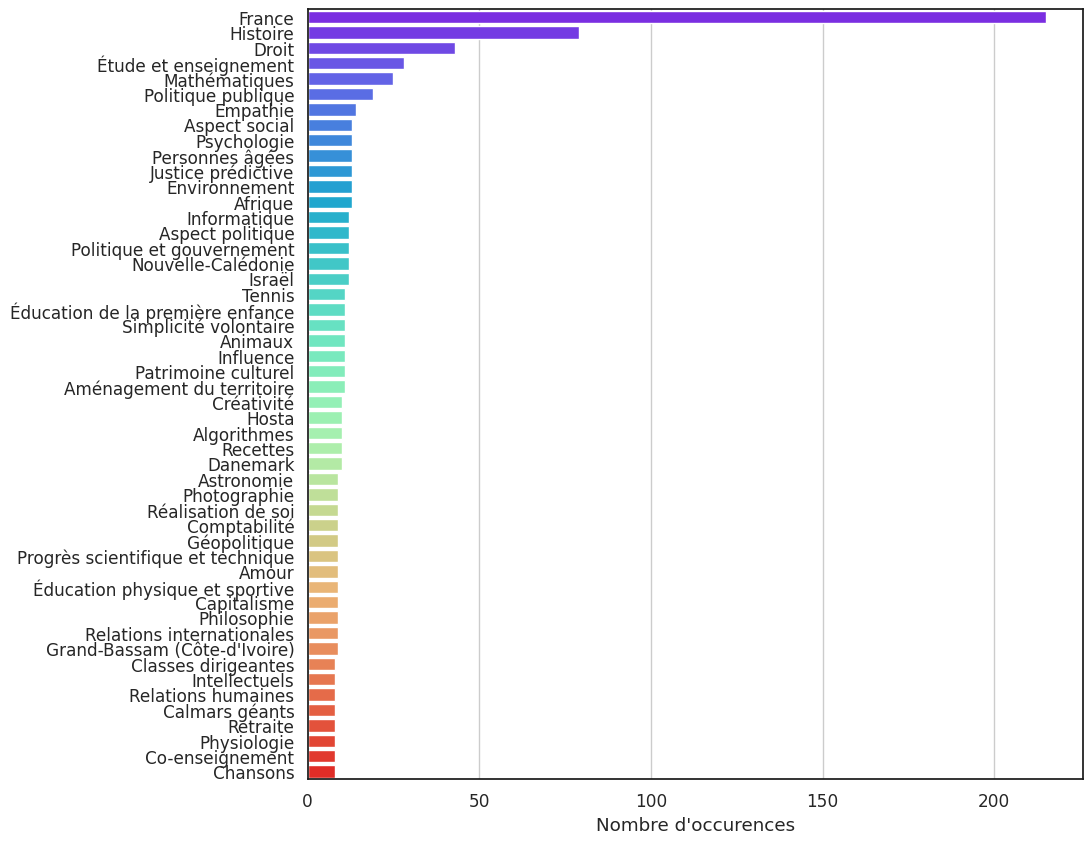

In [21]:
plot_barplot_of_tags(
    keywords,
    nb_of_tags=50,
    xlabel="Nombre d'occurences",
    ylabel="",
    figsave="barplot_concept_reindexation.png",
    figsize=(10, 10),
    palette="rainbow",
    orient="h",
)

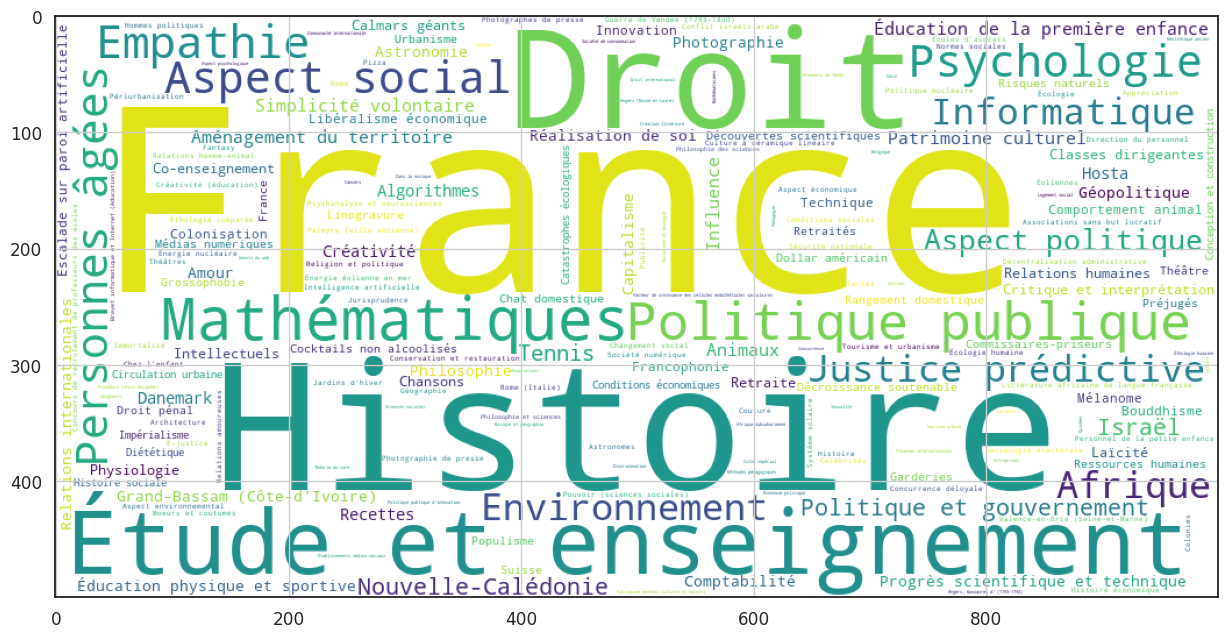

In [22]:
plot_wordcloud(
    keywords,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_reindexation.png",
)

In [23]:
all_possible_concepts =ram["NOM"].to_list()
print(f"Le dictionnaire RAMEAU contient {len(set(all_possible_concepts))} concepts differents")

Le dictionnaire RAMEAU contient 103021 concepts differents


# Multilabel classification

## By Concepts

In [24]:
# Set multibinarizer
mlb = MultiLabelBinarizer()
mlb

MultiLabelBinarizer()

In [25]:
# Binarization
concepts = mlb.fit_transform([all_possible_concepts]) # all_concepts

In [26]:
# Verification que l'on a bien encodé tous les concepts possibles
len(concepts[0])

103021

In [27]:
# Veridication de l'encoage
mlb.classes_[1:20]

array(['"Sprach- und Sachatlas Italiens und der Südschweiz"',
       '"Taalatlas van Noord- en Zuid-Nederland"', "'?d", "'?ntokyo",
       "'Are'are (peuple des îles Salomon)", "'Au keto",
       "'Au keto, Musique d'", "'Au ni aau", "'Au ni aau, Musique d'",
       "'Au ni mako", "'Au ni mako, Musique de", "'Au paina",
       "'Au paina, Musique d'", "'Au porare", "'Au porare, Musique d'",
       "'Au tahana", "'Au tahana, Musique d'", "'Au taka\x91iori",
       "'Au taka‘iori, Musique d'"], dtype=object)

In [29]:
# Binarisation des concepts
sudoc = mlb.transform(df["rameau_concepts"])
afe = mlb.transform(df["rameau_concept_AFE"])
mcr = mlb.transform(df["rameau_concept_MCR"])
jmf = mlb.transform(df["rameau_concept_JMF"])
lpl = mlb.transform(df["rameau_concept_LPL"])
ljz = mlb.transform(df["rameau_concept_LJZ"])
mpd = mlb.transform(df["rameau_concept_MPD"])

In [30]:
from itertools import combinations

index_name = ["sudoc", "afe", "mcr", "jmf", "lpl", "ljz", "mpd"]
concept_list = [sudoc, afe, mcr, jmf, lpl, ljz, mpd]
results = dict()

for names, concept in zip(list(combinations(index_name, 2)), list(combinations(concept_list, 2))):
    print(f"comparing {names[0]} and  {names[1]}")
    name = str(names[0] + '-' + names[1])
    results[name] = label_metrics_report("reindexation_concepts", y_true=concept[0], y_pred=concept[1], zero_division=0)

comparing sudoc and  afe
comparing sudoc and  mcr
comparing sudoc and  jmf
comparing sudoc and  lpl
comparing sudoc and  ljz
comparing sudoc and  mpd
comparing afe and  mcr
comparing afe and  jmf
comparing afe and  lpl
comparing afe and  ljz
comparing afe and  mpd
comparing mcr and  jmf
comparing mcr and  lpl
comparing mcr and  ljz
comparing mcr and  mpd
comparing jmf and  lpl
comparing jmf and  ljz
comparing jmf and  mpd
comparing lpl and  ljz
comparing lpl and  mpd
comparing ljz and  mpd


### Plot results

In [31]:
# Dataframe of results
result_df = pd.DataFrame(results).T

In [32]:
# Plot results
metrics = [
    'Precision - Weighted', 'Recall - Weighted', 'F1_Score - Weighted', 'Jaccard - Weighted',
    'Precision - Sample', 'Recall - Sample', 'F1_Score - Sample', 'Jaccard - Sample']

metrics_radar_plot(
    result_df,
    metrics = metrics,
    remove_identity=True,
    title="Prédiction des concepts",
    savefig="metrics_reindexation_concepts_raw.html",)

#### Metrics on few samples

In [ ]:
# Set Choices
idx = range(49, 55)
compare1 = ["rameau_concepts", sudoc]  # "rameau_concepts", "embeddings_autorites", "rameau_concept_AFE", "rameau_concept_MCR", "rameau_concept_JMF", "rameau_concept_LPL", "rameau_concept_LJZ","rameau_concept_MPD"
compare2 = ["rameau_concept_MPD", mpd]  # "rameau_concepts", "embeddings_autorites", "rameau_concept_AFE", "rameau_concept_MCR", "rameau_concept_JMF", "rameau_concept_LPL", "rameau_concept_LJZ","rameau_concept_MPD"
compare3 = ["embeddings_autorites", embed]  # "rameau_concepts", "embeddings_autorites", "rameau_concept_AFE", "rameau_concept_MCR", "rameau_concept_JMF", "rameau_concept_LPL", "rameau_concept_LJZ","rameau_concept_MPD"

In [ ]:
pd.set_option('display.max_colwidth', None)
df.loc[idx, [compare1[0], compare2[0], compare3[0]]]

rameau_concepts   
49                                                                                                                 [Moeurs et coutumes]  \
50  [Droit, Informatique, Aspect moral, Droit et morale, Justice, Automatisation, Justice prédictive, Procédure pénale, Automatisation]   
51                                                                             [Mathématiciens, Mathématiques, Mathématiques, Histoire]   
52                                                                                                           [Populisme, Christianisme]   
53                                                           [Décision politique, Génie civil, Pratique, Urbanisme, Politique publique]   
54                                                                   [Chat domestique, Comportement animal, Chat domestique, Recherche]   

                                                                                                     rameau_concept_MPD   
49                           [Conditions sociales, Danemark, Moeurs et coutumes, Danemark, Qualité de la vie, Danemark]  \
50                                         [Justice prédictive, Algorithmes, Droit, Informatique, Aspect moral, France]   
51                                                              [Mathématiciens, 19e siècle, Mathématiques, 19e siècle]   
52                                                                                   [Populisme, Religion et politique]   
53  [Urbanisme, Politique publique, France, Eau, Politique publique, France, Environnement, Politique publique, France]   
54               [Chat domestique, Comportement animal, Chat domestique, Aspect socio-culturel, Relations homme-animal]   

                                                                                                                                                 embeddings_autorites  
49                             [Danois, Moeurs et coutumes, Dandys, Inquiétude, Roman suédois, Traductions françaises, Caractère national danois, Secrets de famille]  
50               [Justice prédictive, E-justice, Droit, Informatique, Aspect moral, Procédure pénale, Aspect moral, Automatisation, Aspect moral, Algorithmes, Droit]  
51                   [Fourier,  Séries de, Ondelettes, Fourier,  Analyse de, Flûte, Histoire, Musique et mathématiques, Fourier,  Analyse de, Problèmes et exercices]  
52                                                       [Coexistence religieuse, Religion et politique, Christianisme, Religions, Islam et État, Islam et politique]  
53  [Décision politique, Politique publique, Logement, Politique publique, Politique publique, Évaluation, Sociologie politique, Administration publique, Sociologie]  
54              [Chat domestique, Comportement animal, Chat domestique, Chat domestique, Histoire, Chats, Médias et culture, Chat domestique, Ouvrages humoristiques]

In [ ]:
concept_list = [compare1[1][idx], compare2[1][idx]]
index_name = [compare1[0], compare2[0]]
results = dict()

name = str(index_name[0] + '-' + index_name[1])
results[name] = label_metrics_report("reindexation_concepts", y_true=concept_list[0], y_pred=concept_list[1], zero_division=0)
result_df = pd.DataFrame(results)
result_df.drop(index=["F1-measure", "Jaccard", "Precision", "Recall"])

rameau_concepts-rameau_concept_MPD
Accuracy                                            0.0
Brier Loss                                          NaN
F1_Score - Macro                               0.000116
F1_Score - Sample                              0.587749
F1_Score - Weighted                            0.545455
Hamming Loss                                   0.000028
Jaccard - Macro                                0.000116
Jaccard - Sample                               0.427249
Jaccard - Weighted                             0.545455
Precision - Macro                              0.000116
Precision - Sample                             0.633333
Precision - Weighted                           0.545455
Recall - Macro                                 0.000116
Recall - Sample                                0.622222
Recall - Weighted                              0.545455

In [ ]:
# Plot results
metrics_radar_plot(
    result_df.T,
    metrics=metrics,
    title="Prédiction des concepts par Indexeur")

## By indexation Chains

### Get indexation chains

In [33]:
# Mettre à plat TOUTES les chaines d'indexation
pattern = r';;\s*(?![^()$]*\))'

for col in index_columns:
    name = col.split("_")[1]
    print("Dealing with: ", name)
    new_col = str('rameau_index_chain_' + name)
    df[new_col] = df[col].apply(lambda x: re.split(pattern, str(x)))


Dealing with:  AFE
Dealing with:  MCR
Dealing with:  JMF
Dealing with:  LPL
Dealing with:  LJZ
Dealing with:  MPD


### Explore chains

In [34]:
df.columns

Index(['N°ordre', 'PPN', 'TITRE', 'RESUME', 'INDEX_UNI_AFE', 'INDEX_AFE',
       'INDEX_UNI_MCR', 'INDEX_MCR', 'INDEX_UNI_JMF', 'INDEX_JMF',
       'INDEX_UNI_LPL', 'INDEX_LPL', 'INDEX_UNI_LJZ', 'INDEX_LJZ',
       'INDEX_UNI_MPD', 'INDEX_MPD', 'RAMEAU_CHECKED', 'rameau_chaines_index',
       'rameau_concepts', 'nb_chaine_index_rameau', 'nb_chaine_index_AFE',
       'nb_chaine_index_MCR', 'nb_chaine_index_JMF', 'nb_chaine_index_LPL',
       'nb_chaine_index_LJZ', 'nb_chaine_index_MPD', 'rameau_concept_AFE',
       'rameau_concept_MCR', 'rameau_concept_JMF', 'rameau_concept_LPL',
       'rameau_concept_LJZ', 'rameau_concept_MPD', 'rameau_index_chain_AFE',
       'rameau_index_chain_MCR', 'rameau_index_chain_JMF',
       'rameau_index_chain_LPL', 'rameau_index_chain_LJZ',
       'rameau_index_chain_MPD'],
      dtype='object')

In [35]:
col_to_keep = [
    "PPN", "rameau_chaines_index", "rameau_index_chain_AFE",
    "rameau_index_chain_MCR", "rameau_index_chain_JMF",
    "rameau_index_chain_LPL", "rameau_index_chain_LJZ", "rameau_index_chain_MPD"]

df_index_chain_pivot = pd.melt(df[col_to_keep], id_vars=["PPN"])
df_index_chain_pivot

PPN                variable   
0    000308838    rameau_chaines_index  \
1    003632806    rameau_chaines_index   
2    047450037    rameau_chaines_index   
3    058296182    rameau_chaines_index   
4    059911174    rameau_chaines_index   
..         ...                     ...   
695  23690454X  rameau_index_chain_MPD   
696  24155859X  rameau_index_chain_MPD   
697  25561280X  rameau_index_chain_MPD   
698  26117309X  rameau_index_chain_MPD   
699  26753177X  rameau_index_chain_MPD   

                                                 value  
0    [Bureaucratie, Classes dirigeantes, Classes di...  
1              [Intellectuels, Intellectuels français]  
2                                         [Bouddhisme]  
3    [Chaos (théorie des systèmes), Incertitude, Li...  
4    [Pouvoir (sciences sociales) -- Histoire, Rite...  
..                                                 ...  
695  [Patrimoine culturel -- Droit, Patrimoine cult...  
696  [Installations sonores (art), Art -- Méthodes ...  
697  [Mouvements sociaux -- France -- 2000-...., Po...  
698  [Chansons -- Thèmes, motifs, Musique et géogra...  
699  [Société numérique, Algorithmes -- Utilisation...  

[700 rows x 3 columns]

In [36]:
chains=df_index_chain_pivot["value"]
index_chains = flatten(chains)
print(f"Le dataset contient {len(set(index_chains))} chaines d'indexation differentes")

Le dataset contient 1183 chaines d'indexation differentes


In [37]:
# remove strange characters
index_chains2 = [x.lstrip(r";|''").rstrip(r";|''") for x in index_chains]
print(f"Le dataset contient {len(set(index_chains2))} chaines d'indexation differentes")

Le dataset contient 1183 chaines d'indexation differentes


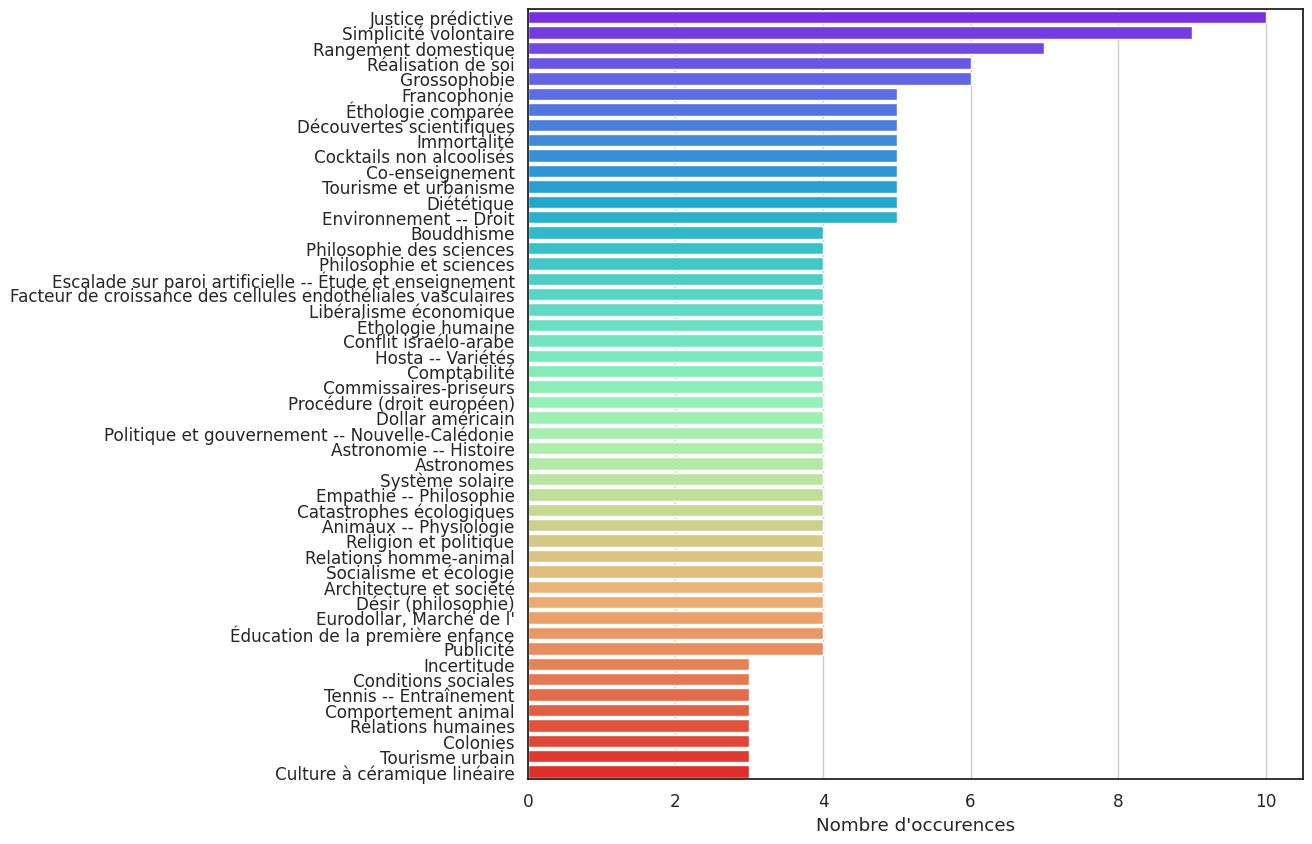

In [38]:
plot_barplot_of_tags(
    index_chains,
    nb_of_tags=50,
    xlabel="Nombre d'occurences",
    ylabel="",
    figsave="barplot_indexationChains_reindexation.png",
    figsize=(10, 10),
    palette="rainbow",
    orient="h",
)

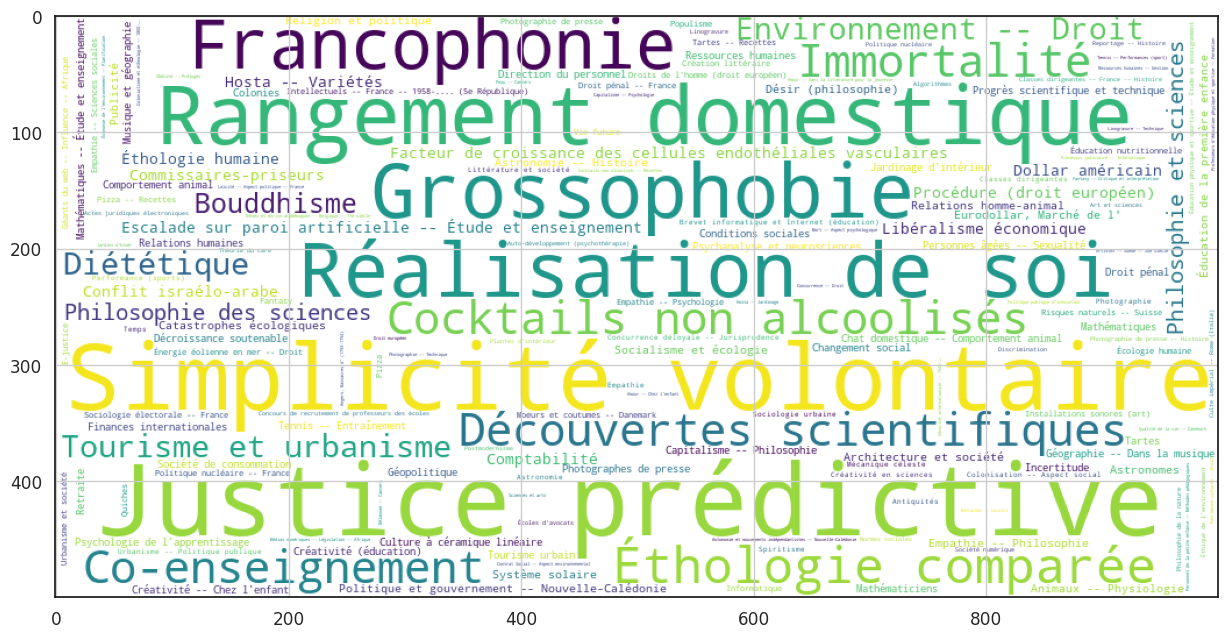

In [39]:
plot_wordcloud(
    index_chains,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_index_chains_reindexation.png",
)

In [41]:
# Binarization et vérification de l'encodage
mlb_chains = MultiLabelBinarizer(sparse_output=True)
index_chains_rameau = mlb_chains.fit_transform([index_chains]) # all indexation chains
mlb_chains.classes_

array(['Acceptation de soi', 'Actes juridiques électroniques',
       'Acteurs -- France', ..., 'Éthologie humaine',
       "Études d'impact (administration publique)",
       'Évolution du comportement'], dtype=object)

In [42]:
# Binarization
sudoc_chains = mlb_chains.transform(df["rameau_chaines_index"])
afe_chains = mlb_chains.transform(df["rameau_index_chain_AFE"])
mcr_chains = mlb_chains.transform(df["rameau_index_chain_MCR"])
jmf_chains = mlb_chains.transform(df["rameau_index_chain_JMF"])
lpl_chains = mlb_chains.transform(df["rameau_index_chain_LPL"])
ljz_chains = mlb_chains.transform(df["rameau_index_chain_LJZ"])
mpd_chains = mlb_chains.transform(df["rameau_index_chain_MPD"])

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning:

unknown class(es) ['nan'] will be ignored



In [44]:
# Vérification de l'encodage
mlb_chains.inverse_transform(afe_chains)

[('Pouvoir communautaire -- France',
  'Classes dirigeantes -- France -- Histoire'),
 ('Intellectuels -- France -- 1958-.... (5e République)',),
 ('Bouddhisme',),
 ('Philosophie et sciences',),
 ('Empereurs -- Rome (Italie)', 'Culte impérial -- Rome (Italie)'),
 ('Escalade sur paroi artificielle -- Étude et enseignement',
  'Escalade sur paroi artificielle -- Méthodes pédagogiques'),
 ('Brevet Informatique et Internet (pédagogie)', 'Informatique'),
 ('Énergie éolienne en mer -- Droit',
  'Éoliennes -- Aménagement',
  'Éoliennes -- Construction et conception'),
 ('Autonomie et mouvements indépendantistes -- Nouvelle-Calédonie',
  'Politique et gouvernement -- Nouvelle-Calédonie'),
 ('Francophonie',),
 ('Mélanome -- Cancers', 'Peau -- Cancers'),
 ('Système solaire', 'Astronomie -- Histoire', 'Astronomes'),
 ('Libéralisme économique', 'Économistes -- 20e siècle'),
 ('Mobilités urbaines -- Histoire sociale -- France',
  'Transports urbains -- Histoire sociale -- France'),
 ('Tennis -- Perf

In [45]:
# Compute metrics
from itertools import combinations

concept_list = [sudoc_chains, afe_chains, mcr_chains, jmf_chains, lpl_chains, ljz_chains, mpd_chains]
index_name = ["sudoc", "afe", "mcr", "jmf", "lpl", "ljz", "mpd"]

result_chains = dict()

for names, concept in zip(list(combinations(index_name, 2)), list(combinations(concept_list, 2))):
    print(f"comparing {names[0]} and  {names[1]}")
    name = str(names[0] + '-' + names[1])
    result_chains[name] = label_metrics_report("reindexation_chains", concept[0], concept[1], zero_division=0)

comparing sudoc and  afe
comparing sudoc and  mcr
comparing sudoc and  jmf
comparing sudoc and  lpl
comparing sudoc and  ljz
comparing sudoc and  mpd
comparing afe and  mcr
comparing afe and  jmf
comparing afe and  lpl
comparing afe and  ljz
comparing afe and  mpd
comparing mcr and  jmf
comparing mcr and  lpl
comparing mcr and  ljz
comparing mcr and  mpd
comparing jmf and  lpl
comparing jmf and  ljz
comparing jmf and  mpd
comparing lpl and  ljz
comparing lpl and  mpd
comparing ljz and  mpd


### Plot results

In [46]:
# Exemple de metrics
label_metrics_report("reindexation_chains", y_true=sudoc[0:5], y_pred=afe[0:5], zero_division=0, print_metrics=True)

------reindexation_chains Model Metrics-----
Accuracy: 0.2000
Hamming Loss: 0.0000\Brier score Loss: nan
Precision:
  - Macro: 0.0000
  - Micro: 0.5000
Recall:
  - Macro: 0.0000
  - Micro: 0.2105
F1-measure:
  - Macro: 0.0000
  - Micro: 0.2963
Jaccard similarity:
  - Macro: 0.0000
  - Micro: 0.1739


/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



{'Hamming Loss': 3.688568350142204e-05,
 'Brier Loss': nan,
 'Accuracy': 0.2,
 'Precision - Macro': 3.882703526465478e-05,
 'Recall - Macro': 3.882703526465478e-05,
 'F1_Score - Macro': 3.882703526465478e-05,
 'Jaccard - Macro': 3.882703526465478e-05,
 'Precision - Weighted': 0.21052631578947367,
 'Recall - Weighted': 0.21052631578947367,
 'F1_Score - Weighted': 0.21052631578947367,
 'Jaccard - Weighted': 0.21052631578947367,
 'Precision - Sample': 0.6666666666666666,
 'Recall - Sample': 0.36190476190476184,
 'F1_Score - Sample': 0.42777777777777776,
 'Jaccard - Sample': 0.35357142857142854,
 'Precision': {'Macro': 3.882703526465478e-05,
  'Micro': 0.5,
  'Sample': 0.6666666666666666},
 'Recall': {'Macro': 3.882703526465478e-05,
  'Micro': 0.21052631578947367,
  'Sample': 0.36190476190476184},
 'F1-measure': {'Macro': 3.882703526465478e-05,
  'Micro': 0.2962962962962963,
  'Sample': 0.42777777777777776},
 'Jaccard': {'Macro': 3.882703526465478e-05,
  'Micro': 0.17391304347826086,
  'Sa

### Plot results

In [47]:
# Dataframe of results
result_chains_df = pd.DataFrame(result_chains).T

In [48]:
# Plot results
metrics_radar_plot(
    result_chains_df,
    metrics=metrics,
    remove_identity=True,
    title="Prédiction des chaines d'indexation",
    savefig="metrics_reindexation_Chains_raw.html",)

## Bag of words (tf-idf or CountVectorizer)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### tfID vectorizer

In [ ]:
def identity_tokenizer(text):
    return text
vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, ngram_range=(1,3), lowercase=False)

In [ ]:
# Vectorization
vectorised_concepts = vectorizer.fit_transform(labels)
autorites = vectorizer.get_feature_names_out()

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

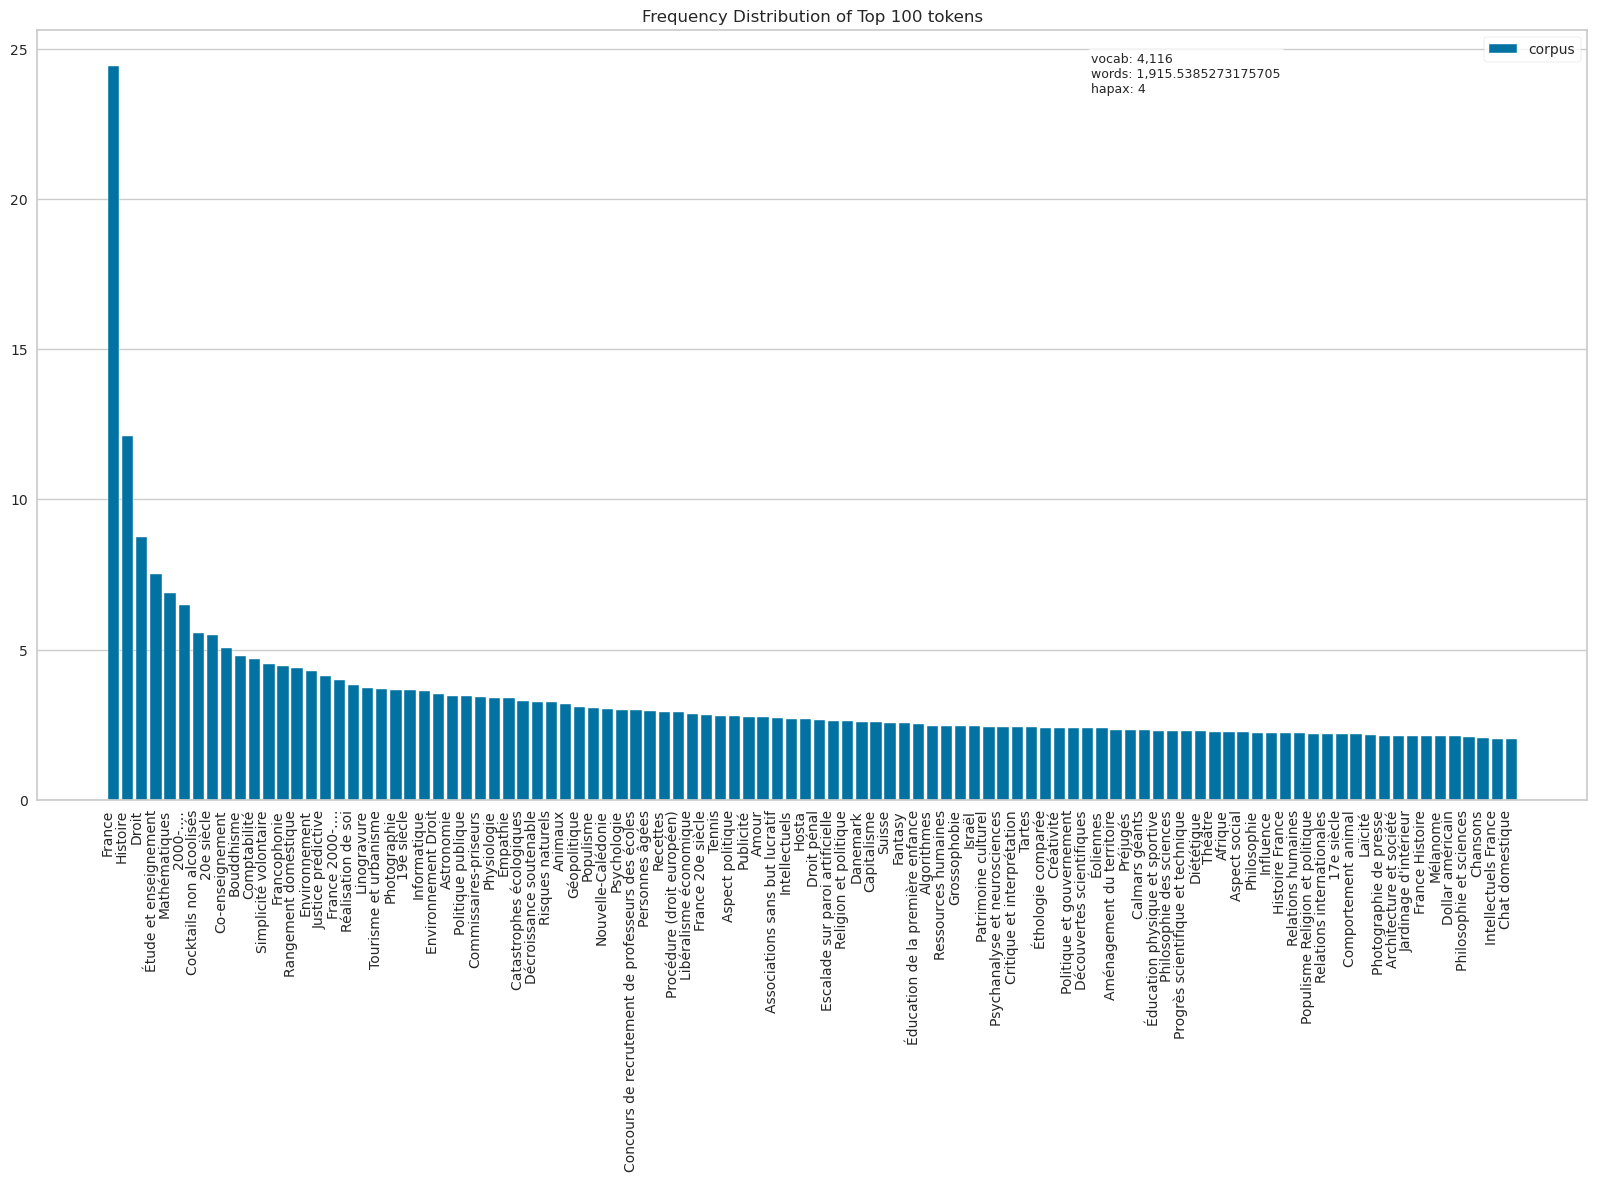

<Axes: title={'center': 'Frequency Distribution of Top 100 tokens'}>

In [ ]:
from yellowbrick.text import FreqDistVisualizer
plt.figure(figsize=(20, 10))
features = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, n=100, orient="v")
visualizer.fit(vectorised_concepts)
visualizer.show()

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/yellowbrick/text/tsne.py:401: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial

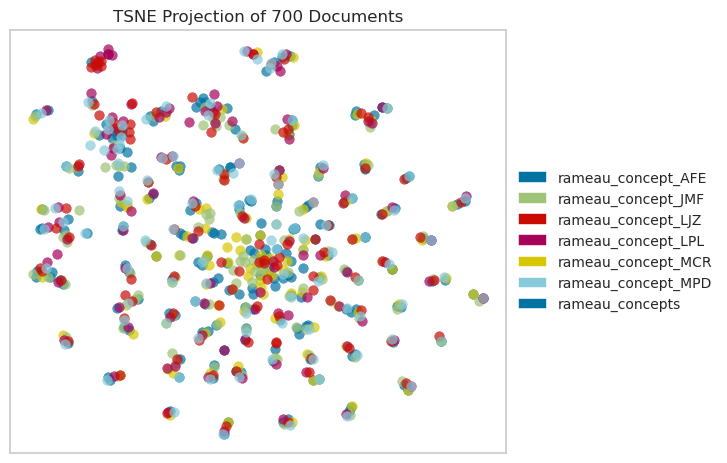

<Axes: title={'center': 'TSNE Projection of 700 Documents'}>

In [ ]:
# Visualize the dataset with T-SNE
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer()
tsne.fit(vectorised_concepts, df_pivot["variable"])
tsne.show()

### Count vectorizer

In [ ]:
vectorizer = CountVectorizer(tokenizer=identity_tokenizer, ngram_range=(1,3), lowercase=False)
vectorised_concepts = vectorizer.fit_transform(df_pivot["value"])

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [ ]:
# Vectorization
vectorised_concepts = vectorizer.fit_transform(labels, df_pivot["variable"])
autorites = vectorizer.get_feature_names_out()

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/yellowbrick/text/tsne.py:401: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial

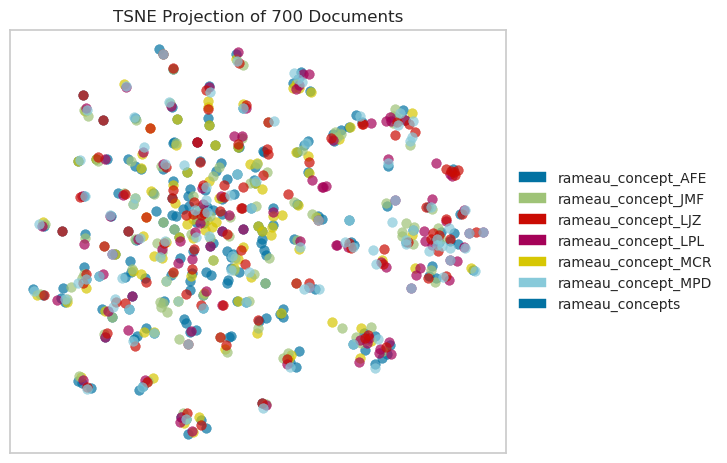

<Axes: title={'center': 'TSNE Projection of 700 Documents'}>

In [ ]:
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer()
tsne.fit(vectorised_concepts, df_pivot["variable"])
tsne.show()

## Test kmeans


In [ ]:
# Select columns to use
concept_cols = [
    "rameau_concepts", "rameau_concept_AFE", "rameau_concept_MCR",
    "rameau_concept_JMF", "rameau_concept_LPL", "rameau_concept_LJZ",
    "rameau_concept_MPD"]
df_for_analysis = df[concept_cols]
labels_encoded = pd.DataFrame(mlb.fit_transform(flatten(df_pivot["value"])))

In [ ]:
len(labels_encoded), len(labels_encoded[0])

(2717, 2717)

In [ ]:
# Clustering based on Kmeans
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [ ]:
# test different clusters
sil = []
davis_bouldin = []
sum_of_squared_distances = []
param_range = range(3,100)
for k in param_range:
    print(f"Clustering with {k} groups")
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(labels_encoded)
    labels = kmeans.labels_
    sum_of_squared_distances.append(kmeans.inertia_)
    silh = silhouette_score(
        labels_encoded, labels, metric="euclidean", sample_size=50000, random_state=200
        )
    dav = davies_bouldin_score(labels_encoded, labels)
    sil.append(silh)
    davis_bouldin.append(dav)

Clustering with 3 groups
Clustering with 4 groups
Clustering with 5 groups
Clustering with 6 groups
Clustering with 7 groups
Clustering with 8 groups
Clustering with 9 groups
Clustering with 10 groups
Clustering with 11 groups
Clustering with 12 groups
Clustering with 13 groups
Clustering with 14 groups
Clustering with 15 groups
Clustering with 16 groups
Clustering with 17 groups
Clustering with 18 groups
Clustering with 19 groups
Clustering with 20 groups
Clustering with 21 groups
Clustering with 22 groups
Clustering with 23 groups
Clustering with 24 groups
Clustering with 25 groups
Clustering with 26 groups
Clustering with 27 groups
Clustering with 28 groups
Clustering with 29 groups
Clustering with 30 groups
Clustering with 31 groups
Clustering with 32 groups
Clustering with 33 groups
Clustering with 34 groups
Clustering with 35 groups
Clustering with 36 groups
Clustering with 37 groups
Clustering with 38 groups
Clustering with 39 groups
Clustering with 40 groups
Clustering with 41 

In [ ]:
# Find optimal values accordin to silhouette and Davis-Bouldin scores
opt_val_sil = param_range[sil.index(max(sil))]
opt_val_db = param_range[davis_bouldin.index(min(davis_bouldin))]

In [ ]:
def plot_metrics(
    sil, davis_bouldin, param_name, param_range, silhouette_color="red", db_color="blue"
):
    """
    Plot the silhouette score and davies_bouldin score for a range of cluster number.

    Parameters:
    -----------
        - sil (list): list of silhouette scores for all values of hyper-parameter range
        - davis_bouldin (list): list of davies-bouldin scores along hyper-parameter range
        - param_name (str): name of the hyper-parameter to be fined-tuned
        - param_range (list) : range of possible values for hyper-parameter tuning
        - silhouette_color (str): color for the silhouette score (defaut: 'red')
        - db_color (str): color for the silhouette score (defaut: 'blue')

    Returns :
    ---------
        - Evolution of silhouette and Davies-bouldin scores along hyper-parameter range
    """

    # plot
    _, ax1 = plt.subplots()
    ax1.set_xlabel(param_name)
    ax1.set_ylabel("Silhouette_score", color=silhouette_color)
    ax1.plot(param_range, sil, color=silhouette_color)
    ax1.tick_params(axis="y", labelcolor=silhouette_color)

    # Adding Twin Axes
    ax2 = ax1.twinx()
    ax2.set_ylabel("Davies_bouldin", color=db_color)
    ax2.plot(param_range, davis_bouldin, color=db_color)
    ax2.tick_params(axis="y", labelcolor=db_color)

    # Show plot
    plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

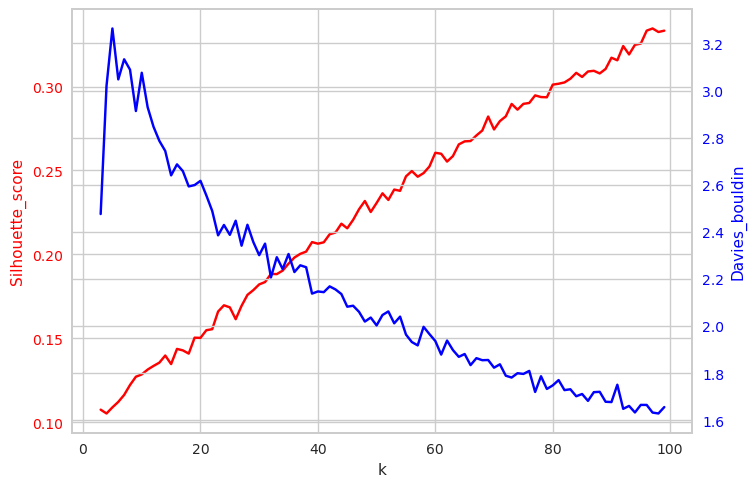

In [ ]:
plot_metrics(sil, davis_bouldin, param_name="k", param_range=param_range, silhouette_color="red", db_color="blue")

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

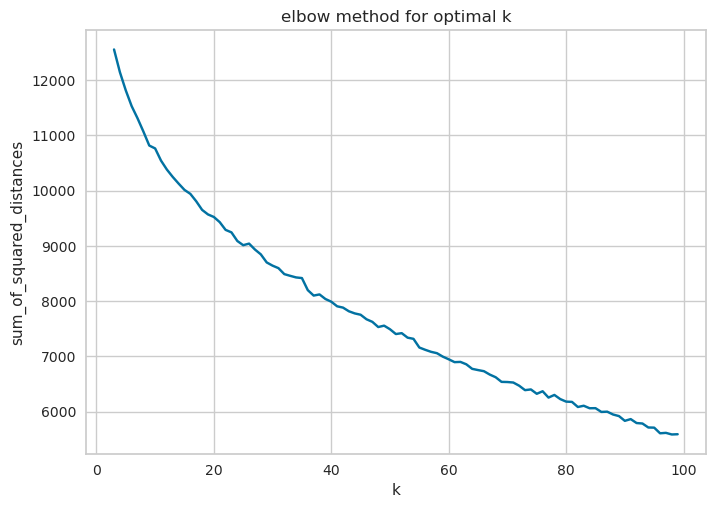

In [ ]:
# Plot inertia
plt.plot(param_range, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

In [ ]:
# Best clustering
#k = opt_val_sil
k = 99
kmeans = KMeans(n_clusters=k)
kmeans.fit(labels_encoded)

KMeans(n_clusters=99)

Graph des Silhouettes



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

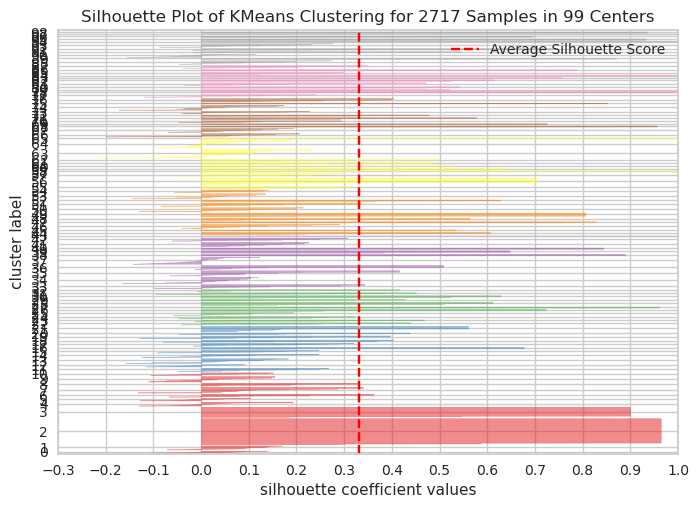

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2717 Samples in 99 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# Graph des silhouettes
from yellowbrick.cluster import SilhouetteVisualizer
print("Graph des Silhouettes\n")
silhouette_vis = SilhouetteVisualizer(kmeans)
silhouette_vis.fit(labels_encoded)
silhouette_vis.poof()

In [ ]:
# Plot clusters
# Fit visualisation pipeline
import sklearn
from sklearn.manifold import TSNE
tsne = TSNE().fit_transform(labels_encoded)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

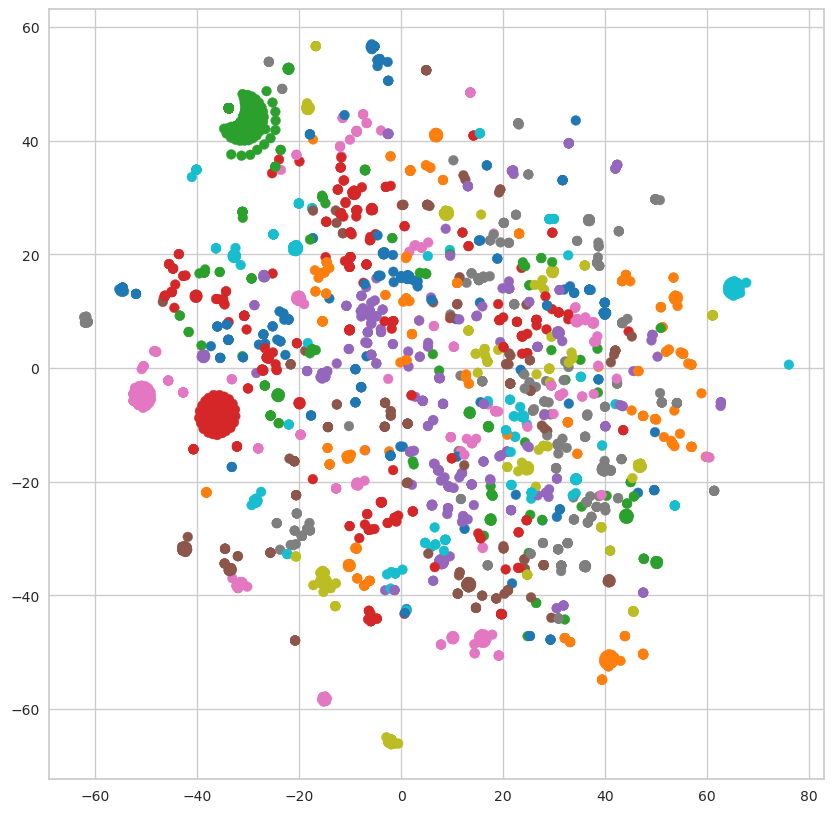

In [ ]:
# Plot TSNE
plt.figure(figsize=(10, 10))
axe = plt.axes()
clusters = kmeans.labels_
num_classes = k
palette = np.array(sns.color_palette("tab10", num_classes))
axe.scatter(x=tsne[:, 0], y=tsne[:, 1], c=palette[clusters.astype(int)])
plt.legend()